In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import numpy as np

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [4]:
config = configClasses.OnlineLearningConfig()
config.EPOCHS = 20
config.L1_REG = 0
config.LR = 1e-3
config.EWC_IMPORTANCE = 500
config.SAVE_PATH = './models/permuted_minst/multikaf'
config.MODEL_NAME = 'multikaf'
config.IS_CONVOLUTIONAL = False
print(config)
    
config_ewc = copy.deepcopy(config)
config_ewc.MODEL_NAME='ewc'
print(config_ewc)

confing_ewt_kaf = copy.copy(config)
confing_ewt_kaf.MODEL_NAME = 'ewc_kaf'
print(confing_ewt_kaf)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 500
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: multikaf
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/multikaf
USE_EWC: True
USE_TENSORBOARD: True

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 500
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: ewc
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/permuted_minst/multikaf
USE_EWC: True
USE_TENSORBOARD: True

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 500
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: ewc

In [5]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

dataset_no_ewt = copy.deepcopy(dataset)

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [6]:
net_multikaf = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.8),  kaf_init_fcn=None,
                             trainable_dict=False, kernel_combination='softmax')

kaf_ewt = Kafnet.KAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.8),  kaf_init_fcn=None)

net_ewt = NoKafnet.MLP(len(dataset.class_to_idx), hidden_size=int(400))

print('Numero di parametri rete multikaf: ', sum([torch.numel(p) for p in net_multikaf.parameters()]))
print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net_ewt.parameters()]))
print('Numero di parametri rete kaf: ', sum([torch.numel(p) for p in kaf_ewt.parameters()]))

Numero di parametri rete multikaf:  517450
Numero di parametri rete classica:  638810
Numero di parametri rete kaf:  479050


In [7]:
trainer_multikaf = Trainer(net_multikaf, copy.deepcopy(dataset), config)

metrics_multikaf = trainer_multikaf.load()
if not metrics_multikaf:
    metrics_multikaf = trainer_multikaf.all_tasks()

Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:17<00:00, 52.17it/s, loss=1.69, batch#=875]
Testing task 0: 219it [00:03, 69.48it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:16<00:00, 52.56it/s, loss=0.582, batch#=875]
Testing task 0: 219it [00:03, 62.36it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:17<00:00, 51.02it/s, loss=0.414, batch#=875]
Testing task 0: 219it [00:03, 70.76it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:16<00:00, 53.47it/s, loss=0.335, batch#=875]
Testing task 0: 219it [00:03, 70.07it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:16<00:00, 47.39it/s, loss=0.286, batch#=875]
Testing task 0: 219it [00:03, 67.94it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:16<00:00, 54.00it/s, loss=0.249, batch#=875]
Testing task 0: 219it [00:03, 69.77it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|██████████

Testing task 1: 219it [00:03, 60.28it/s, batch#=219]
Training task (ewc) 2, epoch 3: 100%|██████████| 875/875 [00:20<00:00, 43.36it/s, loss=0.705, batch#=875]
Testing task 2: 219it [00:03, 64.12it/s, batch#=219]
Testing task 0: 219it [00:03, 63.84it/s, batch#=219]
Testing task 1: 219it [00:03, 65.34it/s, batch#=219]
Training task (ewc) 2, epoch 4: 100%|██████████| 875/875 [00:18<00:00, 46.68it/s, loss=0.66, batch#=875] 
Testing task 2: 219it [00:03, 67.16it/s, batch#=219]
Testing task 0: 219it [00:03, 62.77it/s, batch#=219]
Testing task 1: 219it [00:03, 63.40it/s, batch#=219]
Training task (ewc) 2, epoch 5: 100%|██████████| 875/875 [00:20<00:00, 43.73it/s, loss=0.629, batch#=875]
Testing task 2: 219it [00:03, 65.86it/s, batch#=219]
Testing task 0: 219it [00:03, 66.63it/s, batch#=219]
Testing task 1: 219it [00:03, 67.11it/s, batch#=219]
Training task (ewc) 2, epoch 6: 100%|██████████| 875/875 [00:18<00:00, 47.38it/s, loss=0.604, batch#=875]
Testing task 2: 219it [00:03, 68.37it/s, batch

Testing task 3: 219it [00:03, 67.12it/s, batch#=219]
Testing task 0: 219it [00:03, 65.74it/s, batch#=219]
Testing task 1: 219it [00:03, 66.49it/s, batch#=219]
Testing task 2: 219it [00:03, 65.46it/s, batch#=219]
Training task (ewc) 3, epoch 12: 100%|██████████| 875/875 [00:19<00:00, 44.11it/s, loss=1.03, batch#=875]
Testing task 3: 219it [00:03, 61.35it/s, batch#=219]
Testing task 0: 219it [00:03, 64.71it/s, batch#=219]
Testing task 1: 219it [00:03, 63.40it/s, batch#=219]
Testing task 2: 219it [00:03, 59.92it/s, batch#=219]
Training task (ewc) 3, epoch 13: 100%|██████████| 875/875 [00:19<00:00, 41.30it/s, loss=1.02, batch#=875]
Testing task 3: 219it [00:03, 64.79it/s, batch#=219]
Testing task 0: 219it [00:03, 64.89it/s, batch#=219]
Testing task 1: 219it [00:03, 63.71it/s, batch#=219]
Testing task 2: 219it [00:03, 61.21it/s, batch#=219]
Training task (ewc) 3, epoch 14: 100%|██████████| 875/875 [00:19<00:00, 44.51it/s, loss=1.01, batch#=875]
Testing task 3: 219it [00:03, 67.01it/s, batch

In [8]:
trainer_kaf_ewt = Trainer(kaf_ewt, copy.deepcopy(dataset), confing_ewt_kaf)

metrics_kaf_ewt = trainer_kaf_ewt.load()
if not metrics_kaf_ewt:
    metrics_kaf_ewt = trainer_kaf_ewt.all_tasks()

Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:06<00:00, 129.19it/s, loss=1.13, batch#=875]
Testing task 0: 219it [00:01, 187.62it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:06<00:00, 128.94it/s, loss=0.467, batch#=875]
Testing task 0: 219it [00:01, 183.67it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:06<00:00, 129.15it/s, loss=0.363, batch#=875]
Testing task 0: 219it [00:01, 189.68it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:06<00:00, 129.38it/s, loss=0.316, batch#=875]
Testing task 0: 219it [00:01, 194.62it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:06<00:00, 128.15it/s, loss=0.286, batch#=875]
Testing task 0: 219it [00:01, 191.03it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:06<00:00, 128.36it/s, loss=0.265, batch#=875]
Testing task 0: 219it [00:01, 185.75it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100

Testing task 2: 219it [00:01, 193.50it/s, batch#=219]
Testing task 0: 219it [00:01, 192.97it/s, batch#=219]
Testing task 1: 219it [00:01, 194.88it/s, batch#=219]
Training task (ewc) 2, epoch 3: 100%|██████████| 875/875 [00:08<00:00, 102.57it/s, loss=0.503, batch#=875]
Testing task 2: 219it [00:01, 185.60it/s, batch#=219]
Testing task 0: 219it [00:01, 182.71it/s, batch#=219]
Testing task 1: 219it [00:01, 192.17it/s, batch#=219]
Training task (ewc) 2, epoch 4: 100%|██████████| 875/875 [00:08<00:00, 106.41it/s, loss=0.458, batch#=875]
Testing task 2: 219it [00:01, 192.63it/s, batch#=219]
Testing task 0: 219it [00:01, 193.89it/s, batch#=219]
Testing task 1: 219it [00:01, 187.98it/s, batch#=219]
Training task (ewc) 2, epoch 5: 100%|██████████| 875/875 [00:08<00:00, 106.90it/s, loss=0.427, batch#=875]
Testing task 2: 219it [00:01, 194.71it/s, batch#=219]
Testing task 0: 219it [00:01, 192.99it/s, batch#=219]
Testing task 1: 219it [00:01, 195.37it/s, batch#=219]
Training task (ewc) 2, epoch 6:

Testing task 1: 219it [00:01, 193.65it/s, batch#=219]
Testing task 2: 219it [00:01, 195.86it/s, batch#=219]
Training task (ewc) 3, epoch 11: 100%|██████████| 875/875 [00:08<00:00, 107.61it/s, loss=0.517, batch#=875]
Testing task 3: 219it [00:01, 194.05it/s, batch#=219]
Testing task 0: 219it [00:01, 195.82it/s, batch#=219]
Testing task 1: 219it [00:01, 193.61it/s, batch#=219]
Testing task 2: 219it [00:01, 196.13it/s, batch#=219]
Training task (ewc) 3, epoch 12: 100%|██████████| 875/875 [00:08<00:00, 106.12it/s, loss=0.506, batch#=875]
Testing task 3: 219it [00:01, 192.25it/s, batch#=219]
Testing task 0: 219it [00:01, 190.87it/s, batch#=219]
Testing task 1: 219it [00:01, 187.03it/s, batch#=219]
Testing task 2: 219it [00:01, 185.15it/s, batch#=219]
Training task (ewc) 3, epoch 13: 100%|██████████| 875/875 [00:08<00:00, 106.80it/s, loss=0.497, batch#=875]
Testing task 3: 219it [00:01, 193.39it/s, batch#=219]
Testing task 0: 219it [00:01, 193.33it/s, batch#=219]
Testing task 1: 219it [00:01

In [9]:
trainer_ewt = Trainer(net_ewt, copy.deepcopy(dataset), config_ewc)
    
metrics_ewt = trainer_ewt.load()
if not metrics_ewt:
    metrics_ewt = trainer_ewt.all_tasks()

Multikaf {'fwt': 0.9608928571428571, 'bwt': -0.0027857142857142616, 'remembering': 0.9972142857142857, 'pbwt': 0, 'accuracy': 0.4534571428571429}
Kaf {'fwt': 0.9444285714285714, 'bwt': -0.01211904761904764, 'remembering': 0.9878809523809524, 'pbwt': 0, 'accuracy': 0.44779285714285716}
Ewc {'fwt': 0.8679285714285715, 'bwt': -0.01467857142857141, 'remembering': 0.9853214285714286, 'pbwt': 0, 'accuracy': 0.42450714285714286}


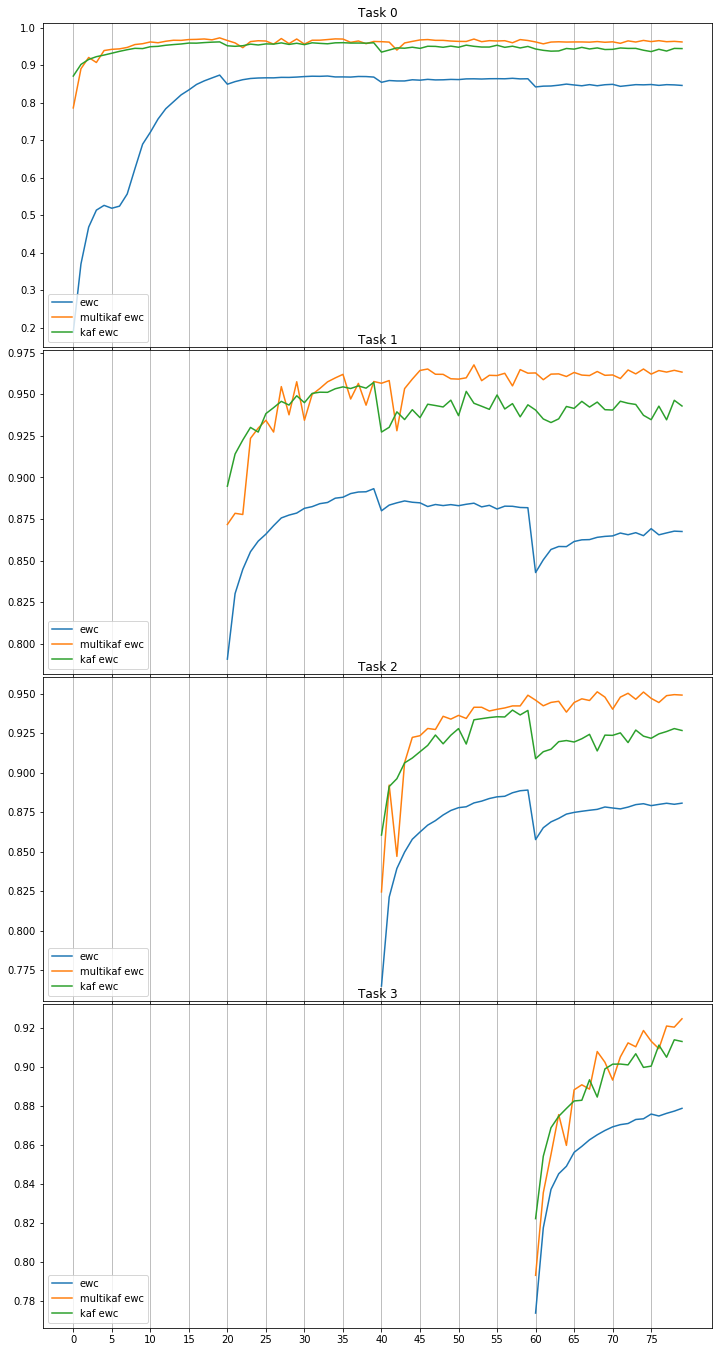

In [10]:
n_task = len(metrics_ewt['tasks'])
tot_epochs = 0

print('Multikaf', metrics_multikaf['metrics'])
print('Kaf', metrics_kaf_ewt['metrics'])
print('Ewc', metrics_ewt['metrics'])


for k, v in metrics_multikaf['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))
             
for k, v in metrics_ewt['tasks'].items():
    tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig = plt.figure(figsize=(12, 24))

ax = None
for i, task in enumerate(metrics_ewt['tasks'].keys()):
        
    ewt = metrics_ewt['tasks'][task]
    no_ewt = metrics_multikaf['tasks'][task]
    kaf = metrics_kaf_ewt['tasks'][task]

    x = range(tot_epochs-len(ewt['accuracy']), tot_epochs)

    ax = fig.add_subplot(n_task, 1, i+1, sharex=ax) 
    
    ax.plot(x, ewt['accuracy'], label='ewc')
    ax.plot(x, no_ewt['accuracy'], label='multikaf ewc')
    ax.plot(x, kaf['accuracy'], label='kaf ewc')


    ax.set_xticks(range(0, tot_epochs, 5),minor=False)
    
    ax.set_title("Task {}".format(task))
    ax.legend(loc="lower left")
    ax.grid(True, axis='x')
    
fig.subplots_adjust(hspace=0.01)
